In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime 

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(autoload_with=engine)

In [13]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [19]:
inspector = inspect(engine)

# Measurement columns
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [21]:
# Station columns
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


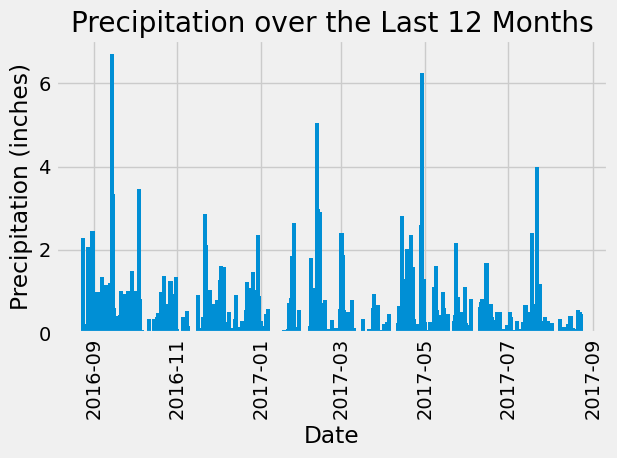

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
latest_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
prcp_df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(prcp_df['date'], prcp_df['precipitation'], width=3)
plt.title('Precipitation over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df['precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number of stations in the dataset
num = session.query(func.count(Station.id)).scalar()
num

9

In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
low = session.query(func.min(Measurement.tobs)).\
                        filter(Measurement.station == 'USC00519281').scalar()
high = session.query(func.max(Measurement.tobs)).\
                        filter(Measurement.station == 'USC00519281').scalar()
avg = session.query(func.avg(Measurement.tobs)).\
                        filter(Measurement.station == 'USC00519281').scalar()

print(f"Low: {low}, High: {high}, Average: {avg}")

Low: 54.0, High: 85.0, Average: 71.66378066378067


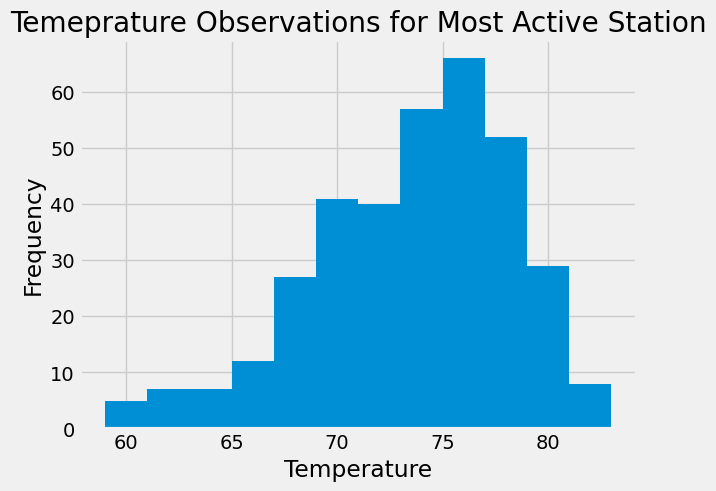

In [63]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(func.max(Measurement.date)).scalar()
latest_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
tobs_df = pd.DataFrame(tobs, columns=['temperature'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(tobs_df['temperature'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temeprature Observations for Most Active Station')
plt.show()

# Close Session

In [65]:
# Close Session
session.close()